In [1]:
import numpy as np

from emukit.test_functions.multi_fidelity import multi_fidelity_branin_function
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import LatinDesign

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from collections import namedtuple

Function = namedtuple('Function', ['name', 'y_scale', 'noise_level', 'do_x_scaling', 'num_data', 'fcn'])

branin = Function(name='branin', y_scale=1, noise_level=[0., 0., 0.], do_x_scaling=True, num_data=[80, 30, 10], 
                    fcn=multi_fidelity_branin_function)

In [3]:
def generate_data(fcn_tuple, n_test_points):
    """
    Generates train and test data for
    """
    
    # A different definition of the parameter space for the branin function was used in the paper
    if fcn_tuple.name == 'branin':
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace([ContinuousParameter('x1', -5., 0.), ContinuousParameter('x2', 10., 15.)])
    else:
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace(space._parameters[:-1])
    
    do_x_scaling = fcn_tuple.do_x_scaling
    
    
    # Generate training data
    
    latin = LatinDesign(new_space)
    X = [latin.get_samples(n) for n in fcn_tuple.num_data]
    
    # Scale X if required
    if do_x_scaling:
        scalings = X[0].std(axis=0)
    else:
        scalings = np.ones(X[0].shape[1])
        
    for x in X:
        x /= scalings
    
    Y = []
    for i, x in enumerate(X):
        Y.append(fcn.f[i](x * scalings))
    
    y_scale = fcn_tuple.y_scale
    
    # scale y and add noise if required
    noise_levels = fcn_tuple.noise_level
    if any([n > 0 for n in noise_levels]):
        for y, std_noise in zip(Y, noise_levels):
            y /= y_scale + std_noise * np.random.randn(y.shape[0], 1)
    
    # Generate test data
    x_test = latin.get_samples(n_test_points)
    x_test /= scalings
    y_test = fcn.f[-1](x_test * scalings)
    y_test /= y_scale

    i_highest_fidelity = (len(fcn_tuple.num_data) - 1) * np.ones((x_test.shape[0], 1))
    x_test = np.concatenate([x_test, i_highest_fidelity], axis=1)
    print(X[1].shape)
    return x_test, y_test, X, Y

In [4]:
def calculate_metrics(y_test, y_mean_prediction, y_var_prediction):
    # R2
    r2 = r2_score(y_test, y_mean_prediction)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_mean_prediction))
    # Test log likelihood
    mnll = -np.sum(scipy.stats.norm.logpdf(y_test, loc=y_mean_prediction, scale=np.sqrt(y_var_prediction)))/len(y_test)
    return {'r2': r2, 'rmse': rmse, 'mnll': mnll}

In [5]:
np.random.seed(123)

x_test, y_test, X, Y = generate_data(branin, 1000)

(30, 2)


In [6]:
X[0].shape, Y[0].shape

((80, 2), (80, 1))

In [7]:
X[1].shape, Y[1].shape

((30, 2), (30, 1))

In [8]:
X[2].shape, Y[2].shape

((10, 2), (10, 1))

In [9]:
x_test.shape, y_test.shape

((1000, 3), (1000, 1))

## Introduce AR1 model and fit all three fidelities of data

In [10]:
#from emukit.examples.multi_fidelity_dgp.baseline_model_wrappers import LinearAutoRegressiveModel

#m1 =  LinearAutoRegressiveModel(X, Y)
#m1.optimize()

In [11]:
#print(m1)

In [12]:
#y_mean, y_var = m1.predict(x_test)

import scipy.stats

#print(calculate_metrics(y_test, y_mean, y_var))

In [13]:
import matplotlib.pyplot as plt

#plt.scatter(y_mean,y_test)
#plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.show()

## To set up the data in three-layer structure
### Cheap data, expensive data, high data

In [14]:
X_branin_cheap = X[0]
X_branin_expensive = X[1]
X_branin_high = X[2]

y_branin_cheap = Y[0]
y_branin_expensive = Y[1]
y_branin_high = Y[2]

import GPy
from GPy.kern import Kern
from GPy import Param, Model

m2 = GPy.models.GPRegression(X_branin_cheap, y_branin_cheap)
m2.optimize()

In [15]:
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -205.71136382413408
Optimization restart 2/10, f = -205.71136382431274
Optimization restart 3/10, f = -205.7113638237936
Optimization restart 4/10, f = -205.71136382380865
Optimization restart 5/10, f = -205.71136382409162
Optimization restart 6/10, f = -205.71136382421872
Optimization restart 7/10, f = -205.71136381987304
Optimization restart 8/10, f = -205.71136382176763
Optimization restart 9/10, f = -205.71136382447344
Optimization restart 10/10, f = -205.71136382420673


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f8bbea80910>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f8bbf4cf650>]}

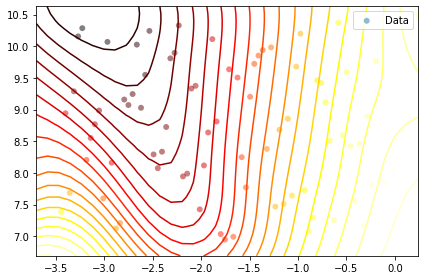

In [16]:
m2.plot()

In [17]:
print(m2)


Name : GP regression
Objective : -205.71136382447344
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      0.5451773789910336  |      +ve      |        
  rbf.lengthscale          |      1.1889798132767944  |      +ve      |        
  Gaussian_noise.variance  |  1.2989794360158266e-05  |      +ve      |        


In [18]:
m2.kern.variance[0], m2.kern.lengthscale[0]

(0.5451773789910336, 1.1889798132767944)

### predicting the expensive data using gp trained with cheap data

In [19]:
muA, vA = m2.predict(X_branin_expensive, full_cov = True)

### Set up the kernel matrix using posterior mean and covariance in mu_A and cov_A

In [20]:
from MFRBF import MFCosine

kMF_A = MFCosine(input_dim=X_branin_expensive.shape[1], variance = 5, lengthscale = 1, mu = muA, v=vA)

In [21]:
kRBF_A = GPy.kern.RBF(input_dim = X_branin_expensive.shape[1])

k_A = kMF_A * kRBF_A

#k_A = kMF_A

m_A = GPy.models.GPRegression(X_branin_expensive, y_branin_expensive, k_A)

m_A.optimize()

In [22]:
m_A.optimize_restarts(num_restarts = 2)

Optimization restart 1/2, f = -38.19640476280557
Optimization restart 2/2, f = -49.267116514976934


In [23]:
print(m_A)


Name : GP regression
Objective : -49.267116514976934
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  mul.MFCosine.variance    |     49.144402826758125  |               |        
  mul.MFCosine.lengtscale  |    -197.94230920905648  |               |        
  mul.rbf.variance         |  7.749827205220757e-05  |      +ve      |        
  mul.rbf.lengthscale      |     1.3423690298014608  |      +ve      |        
  Gaussian_noise.variance  |  2.439003324783352e-05  |      +ve      |        


### Now it is going to get the posterior for x_high

In [24]:
def predict_eff(CovMtx, Y):
    len_expensive = Y.shape[0]
    len_all = CovMtx.shape[0]
    len_high = len_all-len_expensive
    K_ee = CovMtx[len_high:,len_high:]
    K_e = CovMtx[0:len_high,len_high:]
    K_inv = np.linalg.inv(K_ee+0.000001*np.eye(len_expensive))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0:len_high,0:len_high] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, pred_v

In [25]:
s1=m_A.kern.rbf.variance[0]
l1=m_A.kern.rbf.lengthscale[0]
s2=m_A.kern.MFCosine.variance[0]
l2=m_A.kern.MFCosine.lengthscale[0]

#s2 = m_A.MFRBF.variance[0]
#l2 = m_A.MFRBF.lengthscale[0]

In [26]:
s1, l1, s2, l2
#s2, l2

(7.749827205220757e-05,
 1.3423690298014608,
 49.144402826758125,
 -197.94230920905648)

In [27]:
Xnew = np.vstack((X_branin_high,X_branin_expensive))

In [28]:
Xnew.shape

(40, 2)

In [29]:
mu1, v1 = m2.predict(Xnew, full_cov = True)

In [30]:
mu1.shape, v1.shape

((40, 1), (40, 40))

In [31]:
kMF_tmp = MFCosine(input_dim=X_branin_high.shape[1],variance = s2, lengthscale = l2, mu = mu1, v=v1)
kRBF_tmp = GPy.kern.RBF(input_dim = X_branin_high.shape[1], variance = s1, lengthscale = l1)
M1 = kMF_tmp.K(Xnew)
M2 = kRBF_tmp.K(Xnew)
GG = np.multiply(M1, M2)
#GG = M1


pred_mu, pred_cov = predict_eff(GG, y_branin_expensive)

In [32]:
pred_mu.shape, pred_cov.shape

((10, 1), (10, 10))

### Start of training the high layer (3rd layer)

In [33]:
kMF_B = MFCosine(input_dim=X_branin_expensive.shape[1], variance = 2, lengthscale = 1, mu = pred_mu, v=pred_cov)

In [34]:
kRBF_B = GPy.kern.RBF(input_dim = X_branin_expensive.shape[1])

k_B = kMF_B * kRBF_B

#k_B = kMF_B

m_B = GPy.models.GPRegression(X_branin_high, y_branin_high, k_B)

m_B.optimize()

In [35]:
m_B.optimize_restarts(num_restarts = 2)

Optimization restart 1/2, f = -10.749519682399454
Optimization restart 2/2, f = -10.749521729719033


In [36]:
print(m_B)


Name : GP regression
Objective : -10.749521729719033
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mul.MFCosine.variance    |      117.14417433652324  |               |        
  mul.MFCosine.lengtscale  |      -4014.774633048145  |               |        
  mul.rbf.variance         |  0.00010295310440696341  |      +ve      |        
  mul.rbf.lengthscale      |       3.288485104411985  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        


In [37]:
sb1=m_B.kern.rbf.variance[0]
lb1=m_B.kern.rbf.lengthscale[0]
sb2=m_B.kern.MFCosine.variance[0]
lb2=m_B.kern.MFCosine.lengthscale[0]

#sb2 = m_B.MFRBF.variance[0]
#lb2 = m_B.MFRBF.lengthscale[0]

In [38]:
sb1, lb1, sb2, lb2
#sb2, lb2

(0.00010295310440696341,
 3.288485104411985,
 117.14417433652324,
 -4014.774633048145)

## Final stage: prediction the high-level 

In [39]:
X_test = x_test[:,0:2]
X_test.shape
#Y_test=[]
#Y_test_std = []
#Y_test_up=[]
#Y_test_down=[]

#for i in range(X_test.shape[0]):
#    xx = X_test[i].reshape(1,2)
#    Xnew = np.vstack((xx,X_currin_expensive))
#    mu1, v1 = m4.predict(Xnew, full_cov = True)
#    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
#    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
#    M1 = kernMF.K(Xnew)
#    M2 = kernRBF.K(Xnew)
#    GG = np.multiply(M1, M2)
    
#    pred_mu, pred_std = predict_eff(GG, y_currin_expensive)
    
#    Y_test.append(pred_mu)
#    Y_test_std.append(pred_std)
#    Y_test_up.append(pred_mu+1.96*pred_std)
#    Y_test_down.append(pred_mu-1.96*pred_std)

(1000, 2)

In [40]:
Xnew1 = np.vstack((X_test,X_branin_high,X_branin_expensive))
Xnew1.shape

(1040, 2)

In [41]:
mu12_1, cov12_1 = m2.predict(Xnew1,full_cov=True)

In [42]:
mu12_1.shape, cov12_1.shape

((1040, 1), (1040, 1040))

In [43]:
kernMF12_1 = MFCosine(input_dim=2,variance = s2, lengthscale = l2, mu = mu12_1, v=cov12_1)
kernRBF12_1 = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)

M1_12_1 = kernMF12_1.K(Xnew1)
M2_12_1 = kernRBF12_1.K(Xnew1)
GG12_1 = np.multiply(M1_12_1, M2_12_1)
#GG12_1 = M1_12_1 
    
mu12_2, cov12_2 = predict_eff(GG12_1, y_branin_expensive)

In [44]:
mu12_2.shape, cov12_2.shape

((1010, 1), (1010, 1010))

In [45]:
Xnew2 = np.vstack((X_test,X_branin_high))

kernMF12_2 = MFCosine(input_dim=2,variance = sb2, lengthscale = lb2, mu = mu12_2, v=cov12_2)
kernRBF12_2 = GPy.kern.RBF(input_dim = 2, variance = sb1, lengthscale = lb1)

M1_12_2 = kernMF12_2.K(Xnew2)
M2_12_2 = kernRBF12_2.K(Xnew2)
GG12_2 = np.multiply(M1_12_2, M2_12_2)
 
#GG12_2 = M1_12_2
    
mu12_3, cov12_3 = predict_eff(GG12_2, y_branin_high)

In [46]:
mu12_3.shape, cov12_3.shape

((1000, 1), (1000, 1000))

In [47]:
GG12_2.shape

(1010, 1010)

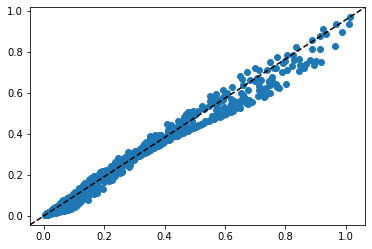

In [48]:
plt.scatter(mu12_3,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

In [49]:
var12_3 = np.diagonal(cov12_3)

In [50]:
mu12_3.shape

(1000, 1)

In [51]:
var12_3.shape

(1000,)

In [52]:
var12_3=np.array(var12_3).reshape(-1,1)

In [53]:
print(calculate_metrics(y_test, mu12_3, var12_3))

{'r2': 0.9660866406912586, 'rmse': 0.03784039272022067, 'mnll': -2.9250329397772212}
